In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2

from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
import albumentations

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from torchmetrics import F1
from pytorch_toolbelt import losses as L
import timm

from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from pytorch_lightning.callbacks import ModelCheckpoint 
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

from pytorch_toolbelt import losses as L

gpu = 1 if torch.cuda.is_available() else 0
print(f'Using {gpu} GPUS')


import warnings
warnings.filterwarnings('ignore')

Using 1 GPUS


In [2]:
root_path = '/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/datasets/'
print(os.listdir(root_path))

['Eucalyptus sp.', 'Brassica', 'Taraxacum', 'Rosmarinus officinalis', 'Tilia', 'Erica.m', 'Lavandula', 'Cistus sp', 'Pinus', 'Cardus', 'Citrus sp', 'Helianthus annuus']


In [3]:
df_train = pd.read_csv('List_train.csv')
df_val = pd.read_csv('List_val.csv')
df_test = pd.read_csv('List_test.csv')

In [4]:
count_train = df_train.groupby('labels').agg({'count'})
count_train['weights'] = 1.02/count_train['name']
count_train['weights_norm'] = count_train['weights']/count_train['weights'].sum()
# count_train['weights_nor'].sum()
count_train

,Unnamed: 0,name,weights,weights_norm
,count,count,,
labels,,,,
Brassica,1198,1198,0.000851,0.029288
Cardus,161,161,0.006335,0.217930
Cistus sp,589,589,0.001732,0.059570
Citrus sp,447,447,0.002282,0.078494
Erica.m,1576,1576,0.000647,0.022263
Eucalyptus sp.,807,807,0.001264,0.043478
Helianthus annuus,780,780,0.001308,0.044983
Lavandula,636,636,0.001604,0.055168


In [5]:
# self.classes = ['Pinus','Erica.m', 'Cistus sp', 'Lavandula', 'Citrus sp', 'Helianthus annuus',
#                 'Eucalyptus sp.', 'Rosmarinus officinalis', 'Brassica', 'Cardus', 'Tilia', 'Taraxacum']
class_weights=torch.Tensor([count_train.loc['Pinus','weights_norm'].item(),
                      count_train.loc['Erica.m','weights_norm'].item(),
                      count_train.loc['Cistus sp','weights_norm'].item(),
                      count_train.loc['Lavandula','weights_norm'].item(),
                      count_train.loc['Citrus sp','weights_norm'].item(),
                      count_train.loc['Helianthus annuus','weights_norm'].item(),
                      count_train.loc['Eucalyptus sp.','weights_norm'].item(),
                      count_train.loc['Rosmarinus officinalis','weights_norm'].item(),
                      count_train.loc['Brassica','weights_norm'].item(),
                      count_train.loc['Cardus','weights_norm'].item(),
                      count_train.loc['Tilia','weights_norm'].item(),
                      count_train.loc['Taraxacum','weights_norm'].item(),
                      ])
class_weights

tensor([0.1456, 0.0223, 0.0596, 0.0552, 0.0785, 0.0450, 0.0435, 0.0790, 0.0293,
        0.2179, 0.0610, 0.1632])

## Weighted Sampler

In [6]:


samples_weight = np.array([count_train.loc[t,'weights_norm'].item() for t in df_train['labels']])
samples_weight=torch.from_numpy(samples_weight)

print(samples_weight.shape)

sampler = WeightedRandomSampler(samples_weight, len(samples_weight))


torch.Size([7669])


In [36]:
# From https://juansensio.com/blog/062_multihead_attention
class Dataset(torch.utils.data.Dataset):
    def __init__(self, mode, df):
        self.mode = mode
        self.df = df 
        self.mean_img = (0.485, 0.456, 0.406 )
        self.std_img = (0.229, 0.224, 0.225)
        self.classes = ['Pinus','Erica.m', 'Cistus sp', 'Lavandula', 'Citrus sp', 'Helianthus annuus',
                        'Eucalyptus sp.', 'Rosmarinus officinalis', 'Brassica', 'Cardus', 'Tilia', 'Taraxacum']
    def __crop_padding(self,img):
        ## convert to gray
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ## set threshold for 0
        _,thresh = cv2.threshold(img_gray,10,255,cv2.THRESH_BINARY)
        ## find contours
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        x,y,w,h = cv2.boundingRect(cnt)
        crop = img[y:y+h,x:x+w,:]
        return crop
    def __getitem__(self, index):
        name_img = self.df['name'].iloc[index]
        label    = self.df['labels'].iloc[index]
        ## READ IMAGE
        image = plt.imread(name_img)
        image = self.__crop_padding(image)
        target = torch.tensor(self.classes.index(label))
        # print(f'Image shape: {image.shape} \t Target:{target}')
        if self.mode=='train':
            train_augm = albumentations.Compose(
              [
                  albumentations.Resize(height=320,width=320),
                  albumentations.Normalize(self.mean_img, self.std_img, max_pixel_value=255.0, always_apply=True),
                  albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15),
                  albumentations.HorizontalFlip(p=0.5),
                  albumentations.VerticalFlip(p=0.5),
              ]
            )
            transformed = train_augm(image=image)
            image=transformed['image']
        else:
            valid_augm = albumentations.Compose(
              [
               albumentations.Resize(height=320,width=320),
               albumentations.Normalize(self.mean_img, self.std_img, max_pixel_value=255.0, always_apply=True)
              ]
            )
            transformed = valid_augm(image=image)
            image=transformed['image']
        image = torch.from_numpy(image.transpose()).float()
        target_oh = torch.nn.functional.one_hot(target, num_classes=12).float()
        data = {"image":image,
                "target_oh":target_oh,
                'target':target,
                'class_name':label } 
        # print(f'Image shape: {image.shape} \t Target:{target}')
        return data
    def __len__(self):
        return len(self.df)

class HoneyDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 4, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset
        self.train_ds =  self.Dataset(mode='train',df= df_train)
        self.val_ds   =  self.Dataset(mode='val', df= df_val)
        self.test_ds   =  self.Dataset(mode='test', df= df_test)
    def train_dataloader(self):
        return DataLoader(self.train_ds,
                          batch_size=8,
                          # shuffle=True,
                          num_workers=0,
                          pin_memory=True,
                          drop_last=True,
                          sampler=sampler
                          )
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=4, shuffle=False, num_workers=0, pin_memory=True, drop_last=True )
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False )
    
dm = HoneyDataModule(Dataset=Dataset)

In [37]:
from torchmetrics import MatthewsCorrcoef as MCC
from torchmetrics import AUROC

In [38]:
val_epoch_loss_CE, val_epoch_acc_CE = [], []
train_epoch_loss_CE, train_epoch_acc_CE = [], []

class LitModel_Focal(pl.LightningModule):
    def __init__(self, model):
        super().__init__( )
        # self.save_hyperparameters()
        self.model = model
        # self.class_weights=class_weights.to('cuda')
        self.focal_loss = L.FocalLoss(alpha=0.25, gamma=2)
        # self.class_weights
        self.f1_score = F1(num_classes=12,average='weighted')
        # self.mcc = MCC(num_classes=12)
        # self.auroc = AUROC(num_classes=12,average='weighted')
        
        
    def forward(self, x):
        return self.model(x)
    def predict(self, x):
        with torch.no_grad():
            y_hat = self(x)
            return y_hat
            # return torch.argmax(y_hat, axis=1)
    def compute_loss_and_metrics(self, batch):
        x, y = batch['image'], batch['target']
        # print(f'X: {x.shape} \t Y: {y.shape}')
        y_hat = self(x)
        # print(f'Output: {y_hat.shape}')
        # loss = F.cross_entropy(y_hat, y, weight=self.class_weights)
        loss = self.focal_loss(y_hat, y)
        # acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        # y1 = y.detach().cpu().numpy()
        # # print(y1.shape)
        # mcc = self.mcc(y_hat, y)
        # auroc = self.auroc(y_hat, y)
        y_hat1 = torch.argmax(y_hat, axis=1)
        # y_hat1 = y_hat1.detach().cpu().numpy()
        # print(y_hat1.shape)
        f1w = self.f1_score( y, y_hat1)#, average='weighted')
        return loss, f1w#, mcc, auroc
    def training_step(self, batch, batch_idx):
        loss, f1w = self.compute_loss_and_metrics(batch)
        self.log('train_loss', loss)
        self.log('train_F1w', f1w, prog_bar=True)
        # self.log('train_mcc', mcc, prog_bar=True)
        # self.log('train_auroc', auroc, prog_bar=True)
        #print(f'Training_step: loss> {loss} acc:{acc}')
        return {'loss':loss,'f1w':torch.tensor(f1w)}#, 'mcc':torch.tensor(mcc), 'auroc':torch.tensor(auroc)}
    
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_train_f1w  = torch.stack([x['f1w'] for x in outputs]).mean()
        # avg_train_mcc  = torch.stack([x['mcc'] for x in outputs]).mean()
        # avg_train_auroc  = torch.stack([x['auroc'] for x in outputs]).mean()

        train_epoch_loss_CE.append(avg_train_loss.item())
        train_epoch_acc_CE.append(avg_train_f1w.item())
        #print(f'Epoch {self.current_epoch} TrainLOSS:{avg_train_loss} TrainACC:{avg_train_acc}  ')
    def validation_step(self, batch, batch_idx):
        loss, f1w= self.compute_loss_and_metrics(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_f1w', f1w, prog_bar=True)
        # self.log('val_mcc', mcc, prog_bar=True)
        # self.log('val_auroc', auroc, prog_bar=True)
        
        return {'val_loss': torch.tensor(loss.item()), 'val_f1w': torch.tensor(f1w)}#, 'val_mcc': torch.tensor(mcc), 'val_auroc': torch.tensor(auroc) }
    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_val_f1w  = torch.stack([x['val_f1w'] for x in outputs]).mean()
        # avg_val_mcc  = torch.stack([x['val_mcc'] for x in outputs]).mean()
        # avg_val_auroc  = torch.stack([x['val_auroc'] for x in outputs]).mean()
        
        self.log('EarlyStop_Log', avg_val_loss.detach(), on_epoch=True, sync_dist=True)
        self.log('avg_val_f1w', avg_val_f1w.detach(), on_epoch=True, sync_dist=True)
        # self.log('avg_val_mcc', avg_val_mcc.detach(), on_epoch=True, sync_dist=True)
        # self.log('avg_val_auroc', avg_val_auroc.detach(), on_epoch=True, sync_dist=True)
        
        val_epoch_loss_CE.append(avg_val_loss.item())
        val_epoch_acc_CE.append(avg_val_f1w.item())
        #print(f'VAL-Epoch {self.current_epoch} LOSS:{avg_val_loss} ACC:{avg_val_acc} ')
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                    T_0=10,
                                                                    T_mult=1,
                                                                    eta_min=1e-7,
                                                                    verbose=True,
                                                                    )

        # lr_scheduler = {'scheduler': MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.5,),'interval': 'epoch','frequency':1}
        return [optimizer], [lr_scheduler]

## Probando MobileNet

In [39]:
# timm.list_models(pretrained=True)
# eff_model = timm.create_model('tf_efficientnet_b7',pretrained='True',num_classes=12)
mobile_model = timm.create_model('mobilenetv3_large_100',pretrained='True',num_classes=12)


In [40]:
mobile_model_focal_sampler  = LitModel_Focal(model=mobile_model)


In [41]:
checkpoint_callback = ModelCheckpoint(dirpath='/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/', 
                                      filename='Mobile-Focal-Sampler-DA-{epoch}-{val_loss:.2f}-{avg_val_f1w:.2f}',
                                      monitor='avg_val_f1w',
                                      verbose=True,
                                      save_last=None,
                                      save_top_k=1,
                                      save_weights_only=False,
                                      mode='max',
                                      auto_insert_metric_name=True,
                                      )


early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
                                    min_delta=0.00,\
                                    patience=5,\
                                    verbose=False,\
                                    mode='min')
    

## Sanity-check
trainer = pl.Trainer(gpus=gpu,
                     callbacks=[checkpoint_callback,
                                early_stop_callback,
                               ],
                    #  deterministic=True,
                     enable_progress_bar=True,
                    #  progress_bar_
                    #  limit_train_batches=2,
                    #  limit_val_batches=2,
                     max_epochs=20)

# Then you call the fit method passing the PL-module and PL-Datamodule, to start training.
trainer.fit(mobile_model_focal_sampler, dm)



    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name       | Type        | Params
-------------------------------------------
0 | model      | MobileNetV3 | 4.2 M 
1 | focal_loss | FocalLoss   | 0     
2 | f1_score   | F1          | 0     
-------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.870    Total estimated model params size (MB)


Epoch     0: adjusting learning rate of group 0 to 1.0000e-04.
Epoch 0:  90%|█████████ | 958/1059 [01:42<00:10,  9.37it/s, loss=0.066, v_num=1666746, train_F1w=1.000] 
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 1059/1059 [01:46<00:00,  9.95it/s, loss=0.066, v_num=1666746, train_F1w=1.000, val_loss=0.0439, val_f1w=0.948]

Epoch 0, global step 957: avg_val_f1w reached 0.94802 (best 0.94802), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Mobile-Focal-Sampler-DA-epoch=0-val_loss=0.04-avg_val_f1w=0.95.ckpt" as top 1


Epoch 1:  90%|█████████ | 958/1059 [01:40<00:10,  9.57it/s, loss=0.0273, v_num=1666746, train_F1w=0.833, val_loss=0.0439, val_f1w=0.948]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 1059/1059 [01:44<00:00, 10.15it/s, loss=0.0273, v_num=1666746, train_F1w=0.833, val_loss=0.037, val_f1w=0.968]

Epoch 1, global step 1915: avg_val_f1w reached 0.96782 (best 0.96782), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Mobile-Focal-Sampler-DA-epoch=1-val_loss=0.04-avg_val_f1w=0.97.ckpt" as top 1


Epoch 2:  90%|█████████ | 958/1059 [01:39<00:10,  9.60it/s, loss=0.0331, v_num=1666746, train_F1w=1.000, val_loss=0.037, val_f1w=0.968]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 1059/1059 [01:44<00:00, 10.17it/s, loss=0.0331, v_num=1666746, train_F1w=1.000, val_loss=0.0214, val_f1w=0.973]

Epoch 2, global step 2873: avg_val_f1w reached 0.97277 (best 0.97277), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Mobile-Focal-Sampler-DA-epoch=2-val_loss=0.02-avg_val_f1w=0.97.ckpt" as top 1


Epoch 3:  90%|█████████ | 958/1059 [01:39<00:10,  9.59it/s, loss=0.0513, v_num=1666746, train_F1w=1.000, val_loss=0.0214, val_f1w=0.973]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 1059/1059 [01:43<00:00, 10.19it/s, loss=0.0513, v_num=1666746, train_F1w=1.000, val_loss=0.0209, val_f1w=0.984]

Epoch 3, global step 3831: avg_val_f1w reached 0.98432 (best 0.98432), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Mobile-Focal-Sampler-DA-epoch=3-val_loss=0.02-avg_val_f1w=0.98.ckpt" as top 1


Epoch 4:  90%|█████████ | 958/1059 [01:39<00:10,  9.60it/s, loss=0.0246, v_num=1666746, train_F1w=1.000, val_loss=0.0209, val_f1w=0.984]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 1059/1059 [01:43<00:00, 10.19it/s, loss=0.0246, v_num=1666746, train_F1w=1.000, val_loss=0.0141, val_f1w=0.982]

Epoch 4, global step 4789: avg_val_f1w was not in top 1


Epoch 5:  90%|█████████ | 958/1059 [01:39<00:10,  9.59it/s, loss=0.00341, v_num=1666746, train_F1w=1.000, val_loss=0.0141, val_f1w=0.982]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 1059/1059 [01:44<00:00, 10.16it/s, loss=0.00341, v_num=1666746, train_F1w=1.000, val_loss=0.0134, val_f1w=0.979]

Epoch 5, global step 5747: avg_val_f1w was not in top 1


Epoch 6:  90%|█████████ | 958/1059 [01:39<00:10,  9.60it/s, loss=0.00447, v_num=1666746, train_F1w=1.000, val_loss=0.0134, val_f1w=0.979]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 1059/1059 [01:44<00:00, 10.17it/s, loss=0.00447, v_num=1666746, train_F1w=1.000, val_loss=0.00886, val_f1w=0.993]

Epoch 6, global step 6705: avg_val_f1w reached 0.99257 (best 0.99257), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Mobile-Focal-Sampler-DA-epoch=6-val_loss=0.01-avg_val_f1w=0.99.ckpt" as top 1


Epoch 7:  90%|█████████ | 958/1059 [01:39<00:10,  9.59it/s, loss=0.00839, v_num=1666746, train_F1w=1.000, val_loss=0.00886, val_f1w=0.993]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 1059/1059 [01:43<00:00, 10.20it/s, loss=0.00839, v_num=1666746, train_F1w=1.000, val_loss=0.00906, val_f1w=0.993]

Epoch 7, global step 7663: avg_val_f1w was not in top 1


Epoch 8:  90%|█████████ | 958/1059 [01:39<00:10,  9.60it/s, loss=0.00674, v_num=1666746, train_F1w=1.000, val_loss=0.00906, val_f1w=0.993]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 1059/1059 [01:44<00:00, 10.18it/s, loss=0.00674, v_num=1666746, train_F1w=1.000, val_loss=0.00629, val_f1w=0.993]

Epoch 8, global step 8621: avg_val_f1w was not in top 1


Epoch 9:  90%|█████████ | 958/1059 [01:39<00:10,  9.63it/s, loss=0.00362, v_num=1666746, train_F1w=1.000, val_loss=0.00629, val_f1w=0.993]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 1059/1059 [01:43<00:00, 10.21it/s, loss=0.00362, v_num=1666746, train_F1w=1.000, val_loss=0.00766, val_f1w=0.990]

Epoch 9, global step 9579: avg_val_f1w was not in top 1


Epoch 10:  90%|█████████ | 958/1059 [01:39<00:10,  9.62it/s, loss=0.00671, v_num=1666746, train_F1w=1.000, val_loss=0.00766, val_f1w=0.990]
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|██████████| 1059/1059 [01:43<00:00, 10.23it/s, loss=0.00671, v_num=1666746, train_F1w=1.000, val_loss=0.00875, val_f1w=0.991]

Epoch 10, global step 10537: avg_val_f1w was not in top 1


Epoch 11:  90%|█████████ | 958/1059 [01:40<00:10,  9.58it/s, loss=0.0158, v_num=1666746, train_F1w=1.000, val_loss=0.00875, val_f1w=0.991]
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|██████████| 1059/1059 [01:44<00:00, 10.15it/s, loss=0.0158, v_num=1666746, train_F1w=1.000, val_loss=0.016, val_f1w=0.987]

Epoch 11, global step 11495: avg_val_f1w was not in top 1


Epoch 12:  90%|█████████ | 958/1059 [01:39<00:10,  9.59it/s, loss=0.0158, v_num=1666746, train_F1w=1.000, val_loss=0.016, val_f1w=0.987]
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|██████████| 1059/1059 [01:44<00:00, 10.17it/s, loss=0.0158, v_num=1666746, train_F1w=1.000, val_loss=0.00957, val_f1w=0.990]

Epoch 12, global step 12453: avg_val_f1w was not in top 1


Epoch 13:  90%|█████████ | 958/1059 [01:39<00:10,  9.61it/s, loss=0.00247, v_num=1666746, train_F1w=1.000, val_loss=0.00957, val_f1w=0.990]
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████| 1059/1059 [01:43<00:00, 10.22it/s, loss=0.00247, v_num=1666746, train_F1w=1.000, val_loss=0.00762, val_f1w=0.990]

Epoch 13, global step 13411: avg_val_f1w was not in top 1


Epoch 13: 100%|██████████| 1059/1059 [01:43<00:00, 10.22it/s, loss=0.00247, v_num=1666746, train_F1w=1.000, val_loss=0.00762, val_f1w=0.990]


In [43]:
%%time
# model_name = "Mobile-Focal-Sampler-DA-epoch=8-val_loss=0.00-avg_val_f1w=1.00.ckpt" # BZ=4
# model_name = "Mobile-Focal-Sampler-DA-epoch=13-val_loss=0.01-avg_val_f1w=0.99.ckpt" ## BZ 32
model_name = "Mobile-Focal-Sampler-DA-epoch=6-val_loss=0.01-avg_val_f1w=0.99.ckpt" ## BZ 8

baseline_model  = LitModel_Focal(model=eff_model)


checkpoint =  torch.load('/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/'+ model_name)

baseline_model.load_state_dict(checkpoint['state_dict'])
targets, preds, pred_score = [],[],[]
baseline_model.to('cuda')
for ii, data in enumerate(dm.test_dataloader()):
    with torch.no_grad():
        targets.append(data['target'].numpy()) #torch.argmax(data['target'],dim=1).numpy()
        # y = y.reshape((-1,1))
        # print(y.shape)
        ## inference
        o = baseline_model.predict(data['image'].to('cuda'))
        o1 = torch.argmax(o, axis=1).cpu().numpy()
        # print(o.shape)
        preds.append(o1)
        pred_score.append(torch.softmax(o,axis=1))
        # print(y)
        # print(o)
        # if ii==2:
        #   break
# print(ii)
preds2 = np.vstack([x for x in preds]).reshape(-1,1)
targets2 = np.vstack([x for x in targets]).reshape(-1,1)
pred_score2 = np.vstack([x.cpu().numpy() for x in pred_score]).reshape(-1,12)

target_names = ['Pinus','Erica.m', 'Cistus sp', 'Lavandula', 'Citrus sp', 'Helianthus annuus',
          'Eucalyptus sp.', 'Rosmarinus officinalis', 'Brassica', 'Cardus', 'Tilia', 'Taraxacum']

print(classification_report(targets2, preds2, target_names=target_names))


CPU times: user 12.6 s, sys: 160 ms, total: 12.8 s
Wall time: 13.6 s


In [44]:
13.6/897

0.01516164994425864

In [31]:
roc_auc_score(targets2[:,0], pred_score2, multi_class='ovr')


0.790692476594383

In [18]:
roc_auc_score(targets2[:,0], pred_score2, multi_class='ovr', average='weighted')


0.9926398813749038

In [19]:
roc_auc_score(targets2[:,0], pred_score2, multi_class='ovo', average='weighted')


0.9907176580489682

In [20]:
cm = confusion_matrix(targets2, preds2, normalize='true')

Text(0.5, 1.0, 'Normalized (rows) Confusion Matrix')

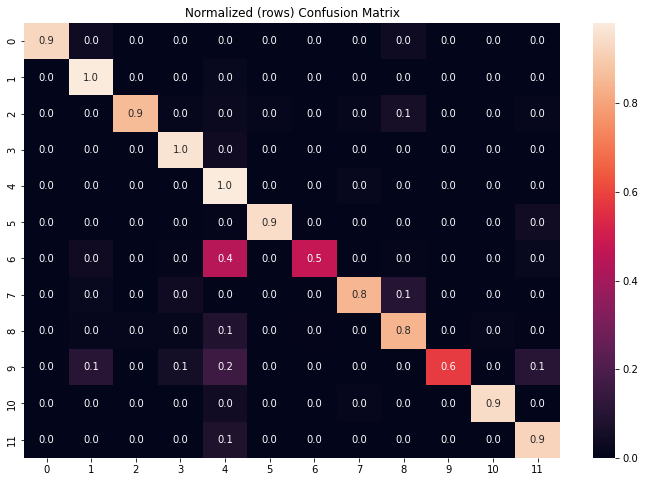

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='.1f')
plt.title('Normalized (rows) Confusion Matrix')

Text(0.5, 1.0, 'Normalized (pred) Confusion Matrix')

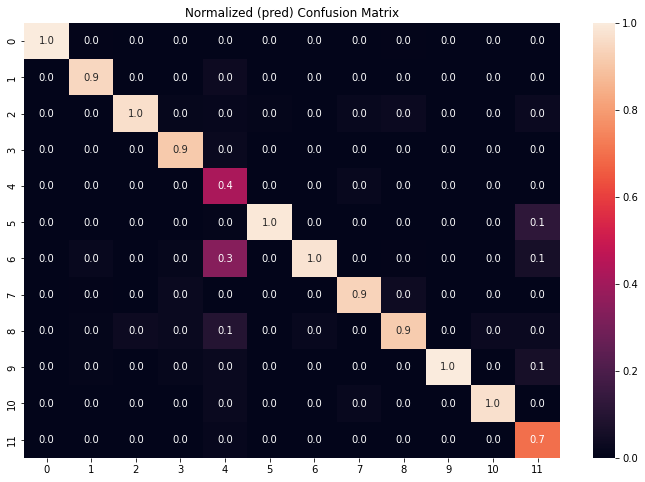

In [22]:
cm = confusion_matrix(targets2, preds2, normalize='pred')
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='.1f')
plt.title('Normalized (pred) Confusion Matrix')